In [120]:
from sympy import *
from dtumathtools import *
from IPython.display import Markdown
import networkx as nx
init_printing(use_latex="mathjax")
mdisplay = lambda x: display(Markdown(str(x)))
nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black", 'node_size':400}

def cprint(input):
    output = ""
    if type(input) == list:
        for i in input:
            output += f"{input}\n\n"
    else:
        output += f"{input}\n\n"
    return output

# Grafteoretisk Modellering af Netværk

## Opgave 1

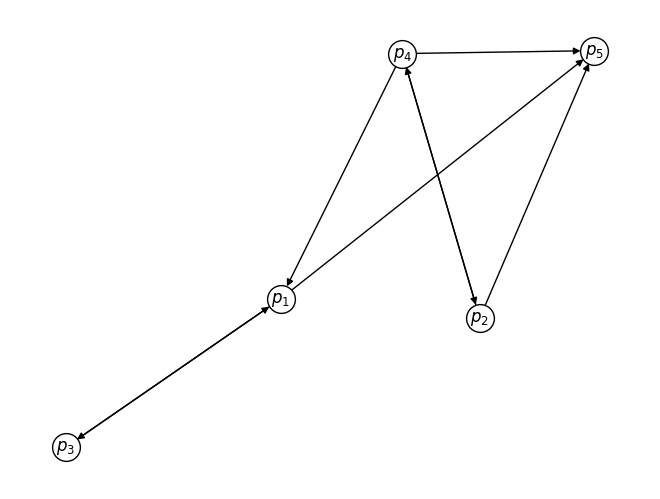

In [121]:
p1,p2,p3,p4,p5 = symbols('$p_1:6$')
V1 = {p1, p2, p3, p4, p5}
E1 = {(p1,p3), (p1,p5),(p2,p4),(p2,p5),(p3,p1),(p4,p1),(p4,p2),(p4,p5)}
W = nx.DiGraph()
W.add_nodes_from(V1, color="white")

W.add_edges_from(E1)
nx.draw(W,**nx_args)

## Opgave 2

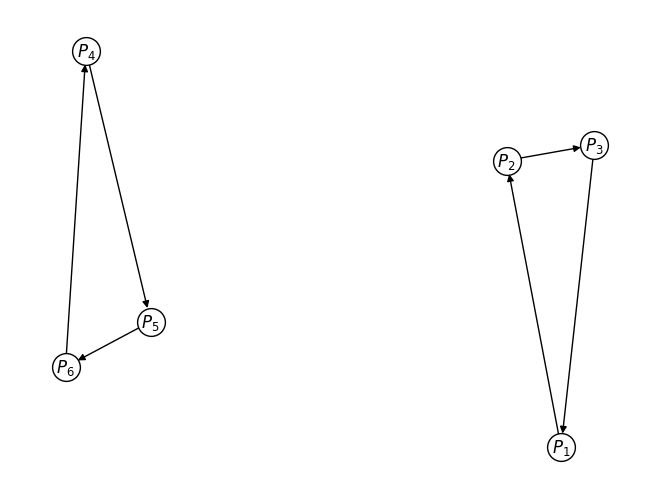

In [122]:
p1,p2,p3,p4,p5,p6 = symbols('$P_1:7$')
V2 = {p1, p2, p3, p4, p5, p6}
E2 = {(p1,p2), (p2,p3),(p3,p1),(p4,p5),(p5,p6),(p6,p4)}
W2 = nx.DiGraph()
W2.add_nodes_from(V2, color="white")

W2.add_edges_from(E2)
nx.draw(W2,**nx_args)

# Opgave 3
#

Jo flere komponenter der er i et netværk, jo svære bliver det at finde en specifik node. Faktisk er det helt umuligt at finde frem til en node i et komponent, hvis man er i et andet komponent til at begynde med. Der er altså ingen links fra den ene hjemmeside til den anden. 

##

In [123]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
W2 = {p1: {p2}, p2: {p3}, p3: {p1}, p4: {p5}, p5: {p6}, p6: {p4}}

Det kan tjekkes om en node i graphen ikke linker til andrer noder, ved at tjekke om nodens value i adjacency listen er den tomme mængde $\emptyset$

## Opgave 5

In [124]:
import numpy as np

# Input: n og k er ikke-negative heltal
# Output: web er en dictionary med n nøgler.
# Værdien af hver nøgle er en liste, der er en delmængde af nøglerne.
def make_web(n,k,kmin=0):
    assert(k < n), "k skal være mindre end n (da man ikke kan linke til sig selv)"
    assert(kmin <= k), "kmin skal være mindre end eller lig med k"
    keys = list(symbols(f"$p_0:{n}$")) 
    web = dict()
    
    for j in keys:
        numlinks = np.random.randint(kmin, k)
        key_choices = keys.copy()
        key_choices.remove(j)
        web[j] = set(np.random.choice(key_choices, numlinks))
    
    return web

print(make_web(4,3, 1))

{$p_0$: {$p_3$}, $p_1$: {$p_0$}, $p_2$: {$p_1$, $p_3$}, $p_3$: {$p_1$}}



## Opgave 6


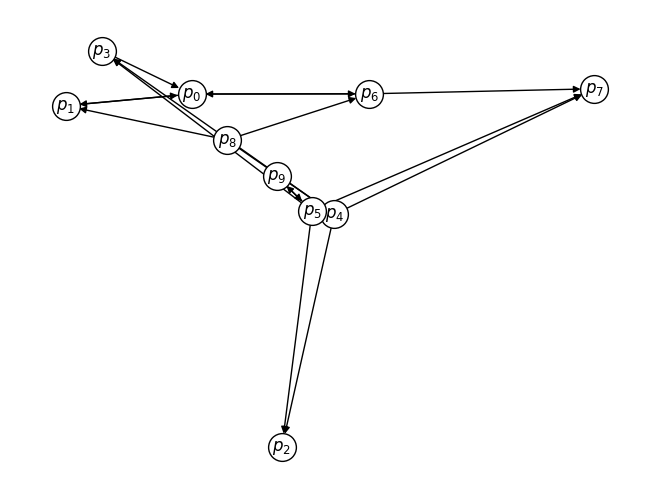

In [125]:
import matplotlib.pyplot as plt

def convert_to_nxgraph(web : dict):
    digraph = nx.DiGraph()
    digraph.add_nodes_from(web.keys())

    for page in web.keys():
        for link_to in web[page]:
            digraph.add_edge(page, link_to)

    return digraph

    # Input: netværk som dictionary
    # Output: Netværk visualiseret som graf
def visualize_graph(web : dict):
    
    digraph = convert_to_nxgraph(web)
    
    plt.figure()
    nx.draw(digraph, **nx_args)
    plt.plot()

visualize_graph(make_web(10, 5, 0))

# Link matricen og Random Surfer Modellen

## Opgave 7

In [126]:
def make_adjacency_matrix(graph):
    A = nx.adjacency_matrix(convert_to_nxgraph(graph))
    b = A.toarray().transpose()
    return b

In [127]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
display(Matrix(make_adjacency_matrix(W1)))




⎡0  0  1  1  0⎤
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎢1  0  0  0  0⎥
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎣1  1  0  1  0⎦

# Opgave 8

In [128]:
def make_link_matrix(graph: dict):

    adjacency_matrix : np.ndarray = make_adjacency_matrix(graph)

    n = adjacency_matrix.shape[0]
    link_matrix = np.zeros((n,n))
    
    for j in range(n):
        N = adjacency_matrix[:,j].sum()
        
        if N == 0:
            link_matrix[:,j] = 1 / n
            continue
            
        for i in range(n):
            if adjacency_matrix[i][j] == 1:
                link_matrix[i][j] = 1 / N
    
    return link_matrix
                

display(Matrix(make_link_matrix(W1)))


⎡0.0  0.0  1.0  0.333333333333333  0.2⎤
⎢                                     ⎥
⎢0.0  0.0  0.0  0.333333333333333  0.2⎥
⎢                                     ⎥
⎢0.5  0.0  0.0         0.0         0.2⎥
⎢                                     ⎥
⎢0.0  0.5  0.0         0.0         0.2⎥
⎢                                     ⎥
⎣0.5  0.5  0.0  0.333333333333333  0.2⎦

Matricerne har elementer samme sted, man tager antal 1-taller i hver søjle og sætter de tilsvarende elementer lig 1 / dette antal.
Hvis en søjle er en 0 vektor, sætter man alle elementer lig $\frac1N$

## Opgave 9

In [129]:
# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step(web, page):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
        
    if len(distribution) == 0:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step(W1, p1))

{$P_3$: 0.5, $P_5$: 0.5}


## Opgave 10

In [130]:
# Input: Et netværk som dictionary og antallet af skridt i random surf simuleringen
# Output: PageRank-værdier for hver side som en dictionary
def random_surf(web, n):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step(web, page)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf(W1,1000))

{$P_1$: 0.307, $P_2$: 0.084, $P_3$: 0.202, $P_4$: 0.098, $P_5$: 0.309}


## Opgave 11

In [131]:
def test_surf_model(model: callable, web: dict):
    output = ""
    for interval in [100, 1000, 10000]:
        output += cprint(f"interval: {interval}")
        for n in range(interval, interval+10, 1):
            output += cprint(model(web, n))
    return output


In [132]:
output = ""
output += cprint(test_surf_model(random_surf, W1))
output += cprint(test_surf_model(random_surf, W2))
mdisplay(output)

interval: 100

{$P_1$: 0.33, $P_2$: 0.08, $P_3$: 0.23, $P_4$: 0.09, $P_5$: 0.27}

{$P_1$: 0.3069306930693069, $P_2$: 0.10891089108910891, $P_3$: 0.24752475247524752, $P_4$: 0.09900990099009901, $P_5$: 0.2376237623762376}

{$P_1$: 0.29411764705882354, $P_2$: 0.09803921568627451, $P_3$: 0.17647058823529413, $P_4$: 0.1568627450980392, $P_5$: 0.27450980392156865}

{$P_1$: 0.34951456310679613, $P_2$: 0.038834951456310676, $P_3$: 0.24271844660194175, $P_4$: 0.0970873786407767, $P_5$: 0.27184466019417475}

{$P_1$: 0.3173076923076923, $P_2$: 0.07692307692307693, $P_3$: 0.25961538461538464, $P_4$: 0.0673076923076923, $P_5$: 0.27884615384615385}

{$P_1$: 0.3142857142857143, $P_2$: 0.08571428571428572, $P_3$: 0.24761904761904763, $P_4$: 0.09523809523809523, $P_5$: 0.2571428571428571}

{$P_1$: 0.2830188679245283, $P_2$: 0.09433962264150944, $P_3$: 0.16981132075471697, $P_4$: 0.12264150943396226, $P_5$: 0.330188679245283}

{$P_1$: 0.2897196261682243, $P_2$: 0.07476635514018691, $P_3$: 0.21495327102803738, $P_4$: 0.11214953271028037, $P_5$: 0.308411214953271}

{$P_1$: 0.3148148148148148, $P_2$: 0.10185185185185185, $P_3$: 0.2222222222222222, $P_4$: 0.09259259259259259, $P_5$: 0.26851851851851855}

{$P_1$: 0.27522935779816515, $P_2$: 0.11926605504587157, $P_3$: 0.1834862385321101, $P_4$: 0.14678899082568808, $P_5$: 0.27522935779816515}

interval: 1000

{$P_1$: 0.306, $P_2$: 0.094, $P_3$: 0.212, $P_4$: 0.105, $P_5$: 0.283}

{$P_1$: 0.3116883116883117, $P_2$: 0.08491508491508491, $P_3$: 0.21478521478521478, $P_4$: 0.09090909090909091, $P_5$: 0.2977022977022977}

{$P_1$: 0.2774451097804391, $P_2$: 0.11477045908183632, $P_3$: 0.18063872255489022, $P_4$: 0.1217564870259481, $P_5$: 0.30538922155688625}

{$P_1$: 0.2951146560319043, $P_2$: 0.10967098703888335, $P_3$: 0.19441674975074777, $P_4$: 0.11266201395812563, $P_5$: 0.288135593220339}

{$P_1$: 0.30278884462151395, $P_2$: 0.09362549800796813, $P_3$: 0.2101593625498008, $P_4$: 0.11055776892430279, $P_5$: 0.28286852589641437}

{$P_1$: 0.30845771144278605, $P_2$: 0.09054726368159204, $P_3$: 0.21194029850746268, $P_4$: 0.1054726368159204, $P_5$: 0.2835820895522388}

{$P_1$: 0.28429423459244535, $P_2$: 0.11232604373757456, $P_3$: 0.19582504970178927, $P_4$: 0.12922465208747516, $P_5$: 0.2783300198807157}

{$P_1$: 0.29096325719960275, $P_2$: 0.09632571996027806, $P_3$: 0.20556107249255212, $P_4$: 0.10327706057596822, $P_5$: 0.3038728897715988}

{$P_1$: 0.29464285714285715, $P_2$: 0.09523809523809523, $P_3$: 0.20634920634920634, $P_4$: 0.10714285714285714, $P_5$: 0.29662698412698413}

{$P_1$: 0.29732408325074333, $P_2$: 0.10208126858275521, $P_3$: 0.19821605550049554, $P_4$: 0.1199207135777998, $P_5$: 0.28245787908820613}

interval: 10000

{$P_1$: 0.308, $P_2$: 0.086, $P_3$: 0.2204, $P_4$: 0.1006, $P_5$: 0.285}

{$P_1$: 0.3060693930606939, $P_2$: 0.0902909709029097, $P_3$: 0.21277872212778723, $P_4$: 0.10328967103289671, $P_5$: 0.28757124287571245}

{$P_1$: 0.3145370925814837, $P_2$: 0.08478304339132174, $P_3$: 0.21995600879824034, $P_4$: 0.09978004399120176, $P_5$: 0.28094381123775247}

{$P_1$: 0.30210936718984305, $P_2$: 0.09417174847545737, $P_3$: 0.2069379186244127, $P_4$: 0.10516844946516045, $P_5$: 0.29161251624512646}

{$P_1$: 0.3023790483806477, $P_2$: 0.0938624550179928, $P_3$: 0.2070171931227509, $P_4$: 0.10805677728908436, $P_5$: 0.28868452618952417}

{$P_1$: 0.29825087456271865, $P_2$: 0.09865067466266866, $P_3$: 0.20419790104947527, $P_4$: 0.10604697651174413, $P_5$: 0.2928535732133933}

{$P_1$: 0.3003198081151309, $P_2$: 0.0925444733160104, $P_3$: 0.20547671397161704, $P_4$: 0.10523685788526883, $P_5$: 0.2964221467119728}

{$P_1$: 0.3069851104227041, $P_2$: 0.08983711402018588, $P_3$: 0.2111521934645748, $P_4$: 0.10212851004296992, $P_5$: 0.28989707204956533}

{$P_1$: 0.30315747402078336, $P_2$: 0.09132693844924061, $P_3$: 0.2099320543565148, $P_4$: 0.10531574740207834, $P_5$: 0.2902677857713829}

{$P_1$: 0.30322709561394745, $P_2$: 0.09271655510040963, $P_3$: 0.21220901188929964, $P_4$: 0.10430612448796084, $P_5$: 0.28754121290838247}



interval: 100

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33, $P_5$: 0.33, $P_6$: 0.34}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33663366336633666, $P_5$: 0.33663366336633666, $P_6$: 0.32673267326732675}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.33980582524271846, $P_2$: 0.3300970873786408, $P_3$: 0.3300970873786408, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33653846153846156, $P_2$: 0.33653846153846156, $P_3$: 0.3269230769230769, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33962264150943394, $P_5$: 0.330188679245283, $P_6$: 0.330188679245283}

{$P_1$: 0.3364485981308411, $P_2$: 0.3364485981308411, $P_3$: 0.32710280373831774, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3302752293577982, $P_2$: 0.3302752293577982, $P_3$: 0.3394495412844037, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

interval: 1000

{$P_1$: 0.333, $P_2$: 0.334, $P_3$: 0.333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3336663336663337, $P_2$: 0.33266733266733267, $P_3$: 0.3336663336663337, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33300099700897307, $P_5$: 0.33300099700897307, $P_6$: 0.3339980059820538}

{$P_1$: 0.3336653386454183, $P_2$: 0.3336653386454183, $P_3$: 0.33266932270916333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.33399602385685884, $P_2$: 0.33300198807157055, $P_3$: 0.33300198807157055, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3326713008937438, $P_2$: 0.3336643495531281, $P_3$: 0.3336643495531281, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3330029732408325, $P_5$: 0.3330029732408325, $P_6$: 0.333994053518335}

interval: 10000

{$P_1$: 0.3334, $P_2$: 0.3333, $P_3$: 0.3333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33336666333366666, $P_2$: 0.33336666333366666, $P_3$: 0.33326667333266674, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333000099970009, $P_2$: 0.3333000099970009, $P_3$: 0.3333999800059982, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33336665333866455, $P_5$: 0.33326669332267095, $P_6$: 0.33336665333866455}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.3333000199880072, $P_2$: 0.3333999600239856, $P_3$: 0.3333000199880072, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33336664334965527, $P_2$: 0.33336664334965527, $P_3$: 0.3332667133006895, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33330002997302427, $P_2$: 0.33339994005395146, $P_3$: 0.33330002997302427, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}





Den varierer meget, selv små skridt i iterations størrelsen varierer ret meget.
Størrelsesordnerne er dog ca. det samme, og den bliver mere konsistent desto højere skridt iterations størrelsen er.

## Opgave 12


In [133]:
import random

# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step_damp(web, page, d):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
    
    if len(distribution) == 0 or random.random() >= d:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step_damp(W1, p1, 0.85))

{$P_3$: 0.5, $P_5$: 0.5}


In [134]:
def random_surf_damp(web, n, d):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step_damp(web, page, d)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf_damp(W1,1000, 0.85))

{$P_1$: 0.304, $P_2$: 0.104, $P_3$: 0.215, $P_4$: 0.114, $P_5$: 0.263}


# Opgave 13

In [135]:
dampening_factor = 0.85
output = ""
output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W1))
# output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W2))
mdisplay(output)

interval: 100

{$P_1$: 0.25, $P_2$: 0.14, $P_3$: 0.17, $P_4$: 0.13, $P_5$: 0.31}

{$P_1$: 0.32673267326732675, $P_2$: 0.1188118811881188, $P_3$: 0.18811881188118812, $P_4$: 0.12871287128712872, $P_5$: 0.2376237623762376}

{$P_1$: 0.27450980392156865, $P_2$: 0.10784313725490197, $P_3$: 0.18627450980392157, $P_4$: 0.08823529411764706, $P_5$: 0.3431372549019608}

{$P_1$: 0.24271844660194175, $P_2$: 0.1650485436893204, $P_3$: 0.13592233009708737, $P_4$: 0.17475728155339806, $P_5$: 0.2815533980582524}

{$P_1$: 0.3269230769230769, $P_2$: 0.08653846153846154, $P_3$: 0.22115384615384615, $P_4$: 0.08653846153846154, $P_5$: 0.27884615384615385}

{$P_1$: 0.2857142857142857, $P_2$: 0.10476190476190476, $P_3$: 0.1619047619047619, $P_4$: 0.13333333333333333, $P_5$: 0.3142857142857143}

{$P_1$: 0.25471698113207547, $P_2$: 0.10377358490566038, $P_3$: 0.18867924528301888, $P_4$: 0.1509433962264151, $P_5$: 0.3018867924528302}

{$P_1$: 0.2897196261682243, $P_2$: 0.1308411214953271, $P_3$: 0.17757009345794392, $P_4$: 0.11214953271028037, $P_5$: 0.2897196261682243}

{$P_1$: 0.32407407407407407, $P_2$: 0.10185185185185185, $P_3$: 0.23148148148148148, $P_4$: 0.09259259259259259, $P_5$: 0.25}

{$P_1$: 0.29357798165137616, $P_2$: 0.14678899082568808, $P_3$: 0.2018348623853211, $P_4$: 0.11926605504587157, $P_5$: 0.23853211009174313}

interval: 1000

{$P_1$: 0.283, $P_2$: 0.109, $P_3$: 0.198, $P_4$: 0.117, $P_5$: 0.293}

{$P_1$: 0.3026973026973027, $P_2$: 0.0989010989010989, $P_3$: 0.2057942057942058, $P_4$: 0.11788211788211789, $P_5$: 0.27472527472527475}

{$P_1$: 0.27345309381237526, $P_2$: 0.11277445109780439, $P_3$: 0.20359281437125748, $P_4$: 0.124750499001996, $P_5$: 0.28542914171656686}

{$P_1$: 0.28913260219341974, $P_2$: 0.1016949152542373, $P_3$: 0.19441674975074777, $P_4$: 0.12662013958125623, $P_5$: 0.288135593220339}

{$P_1$: 0.29382470119521914, $P_2$: 0.1145418326693227, $P_3$: 0.20219123505976094, $P_4$: 0.12250996015936255, $P_5$: 0.26693227091633465}

{$P_1$: 0.27064676616915423, $P_2$: 0.12039800995024875, $P_3$: 0.18009950248756218, $P_4$: 0.1373134328358209, $P_5$: 0.2915422885572139}

{$P_1$: 0.2654075546719682, $P_2$: 0.12326043737574553, $P_3$: 0.18091451292246521, $P_4$: 0.13817097415506957, $P_5$: 0.2922465208747515}

{$P_1$: 0.27209533267130087, $P_2$: 0.1221449851042701, $P_3$: 0.19563058589870905, $P_4$: 0.11717974180734857, $P_5$: 0.2929493545183714}

{$P_1$: 0.2777777777777778, $P_2$: 0.1130952380952381, $P_3$: 0.20436507936507936, $P_4$: 0.125, $P_5$: 0.27976190476190477}

{$P_1$: 0.27651139742319125, $P_2$: 0.1159563924677899, $P_3$: 0.20118929633300298, $P_4$: 0.12388503468780972, $P_5$: 0.28245787908820613}

interval: 10000

{$P_1$: 0.2882, $P_2$: 0.1095, $P_3$: 0.1989, $P_4$: 0.1255, $P_5$: 0.2779}

{$P_1$: 0.2816718328167183, $P_2$: 0.1141885811418858, $P_3$: 0.1964803519648035, $P_4$: 0.1267873212678732, $P_5$: 0.28087191280871915}

{$P_1$: 0.2746450709858028, $P_2$: 0.11777644471105779, $P_3$: 0.19486102779444112, $P_4$: 0.1265746850629874, $P_5$: 0.2861427714457109}

{$P_1$: 0.27651704488653406, $P_2$: 0.11676497050884735, $P_3$: 0.18894331700489853, $P_4$: 0.134259722083375, $P_5$: 0.2835149455163451}

{$P_1$: 0.2824870051979208, $P_2$: 0.11765293882447021, $P_3$: 0.19642143142742902, $P_4$: 0.125749700119952, $P_5$: 0.2776889244302279}

{$P_1$: 0.28375812093953023, $P_2$: 0.11004497751124438, $P_3$: 0.19640179910044978, $P_4$: 0.1251374312843578, $P_5$: 0.2846576711644178}

{$P_1$: 0.27913252048770737, $P_2$: 0.11483110133919648, $P_3$: 0.19188486907855287, $P_4$: 0.13002198680791524, $P_5$: 0.284129522286628}

{$P_1$: 0.28260217847506747, $P_2$: 0.11471969621265114, $P_3$: 0.19966023783351655, $P_4$: 0.12421305086439492, $P_5$: 0.27880483661436994}

{$P_1$: 0.2791766586730616, $P_2$: 0.11330935251798561, $P_3$: 0.19784172661870503, $P_4$: 0.1315947242206235, $P_5$: 0.2780775379696243}

{$P_1$: 0.282445798781097, $P_2$: 0.11289839144769707, $P_3$: 0.19602357877909882, $P_4$: 0.12378859026875812, $P_5$: 0.284843640723349}





Nu kan man se at man får et bedere estimat på pageranken for grafer med flere komponenter.

# Rekursiv Model og Matrix Formulering

## Opgave 14

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)} + \left[ d\sum_{s \in Sinks(W)}\frac{PR_{n}(s)}{N} \right]
\end{equation*}

Første led er sandsynligheden af at man kommer fra en tilfældig hjemmeside, hvor (1-d) er sandsynlighed for at dæmpningen sker. 1/N er sandsynlighen for at P sker. 
Andet led er sandsynlighedn for at man kommer (direkte) fra en anden hjemmeside (d). Ganget med for ethvert hjemmeside der peger på P (q), ganget med sandsynligheden for at man er på q, ganget med chancen for at man trykker på p. 

## Opgave 15

In [136]:
def rank_update(web: dict, page_ranks: dict, page, d):

        """
        Opdaterer værdien af PageRank for en side baseret på den rekursive formel
        Sider uden udgående links --->(sinks)<--- behandles som om de linker til alle sider på nettet.

        Input: 
            web og PageRanks er dictionaries som i outputtet fra "make_web" og "random_surf",
            page er nøglen til den side, hvis rank vi ønsker at opdatere, og
            d er dampingfaktoren.
        Output: 
            PageRank opdateres i henhold til ovenstående formel,
            og denne funktion returnerer et float "increment", den (absolutte) forskel
            mellem den tidligere værdi og den opdaterede værdi af PR(p).
        """
        # inbound_page is the same as q, in the original equation
        # lenth of web.keys is the same as N
        
        # for random pages
        new_page_rank = (1-d)* 1 / len(web)
        
        # for inbound web pages
        new_page_rank += d * sum([
              page_ranks[inbound_page]/len(web[inbound_page]) 
              for inbound_page in web 
              if page in web[inbound_page]
              ])
        
        # for sinks
        new_page_rank += d * sum([
              page_ranks[sink]/len(web) 
              for sink in web 
              if len(web[sink]) == 0
              ])

        return new_page_rank - page_ranks[page]

def recursive_page_rank(web : dict, stopvalue=0.0001, max_iterations=200, d=0.85):
    """
    Implementerer den rekursive version af PageRank-algoritmen ved først at oprette
    en PageRank på 1/N til alle sider (hvor N er det samlede antal sider)
    og derefter anvende "rank_update" gentagne gange, indtil en af de to stopbetingelser
    er opnået:
    stopbetingelse 1: den maksimale ændring fra trin n til trin (n+1) over alle PageRank
    er mindre end stopværdien,
    Stopbetingelse 2: antallet af iterationer har nået "max_iterations".

    Input: web er et dictionary som i outputtet af "make_web", d er dæmpningen,
    stopvalue er et positivt float, max_iterations er et positivt heltal.
    """

    page_ranks = dict()
    for page in web:
        page_ranks[page] = 1/len(web)

    for iteration in range(max_iterations):
        increments = dict()
        
        for page in web:
            increments[page]=rank_update(web,page_ranks,page,d)
        
        if max([ abs(v) for v in increments.values()]) <= stopvalue:
            break
        
        for page in increments:
            page_ranks[page] += increments[page]

    return page_ranks, iteration+1

mdisplay(recursive_page_rank(W2, max_iterations=100, stopvalue=1e-6, d=1))


({$P_1$: 0.16666666666666666, $P_2$: 0.16666666666666666, $P_3$: 0.16666666666666666, $P_4$: 0.16666666666666666, $P_5$: 0.16666666666666666, $P_6$: 0.16666666666666666}, 1)

# Opgave 16

Argumentér for at (▲) kan omskrives til (■).